In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pickle
import gzip
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2025-04-08 20:36:39.913749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744162599.949112    2501 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744162599.960836    2501 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744162600.023392    2501 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744162600.023435    2501 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744162600.023439    2501 computation_placer.cc:177] computation placer alr

In [38]:
class CustomModel:
    def __init__(self, n, k, max_m_value):
        self.n = n
        self.k = k
        self.max_m_value = max_m_value

        self.P_matrices = None
        self.m_heights = None
        self.P_matrices_train = None
        self.P_matrices_test = None
        self.P_matrices_val = None
        self.m_heights_train = None
        self.m_heights_test = None
        self.m_heights_val = None
        self.m_heights_train_aug = None

        self.m_heights_train_exp = None
        self.m_heights_test_exp = None
        self.m_heights_val_exp = None

        self.m_heights_train_mantissa = None
        self.m_heights_test_mantissa = None
        self.m_heights_val_mantissa = None

        self.eval_inputs = None
        self.eval_outputs = None
        self.P_matrices_train_aug = None
        # self.m_heights_log_train_aug = None

        self.train_dataset_exp = None
        self.val_dataset_exp = None

        self.train_dataset_mantissa = None
        self.val_dataset_mantissa = None

        self.model_name_exp = f'model_{self.n}_{self.k}_exp.keras'
        self.model_name_mantissa = f'model_{self.n}_{self.k}_mantissa.keras'
        self.model_exp = None
        self.model_mantissa = None
        self.history_exp = None
        self.history_mantissa = None
    def load_and_preprocess_data(self,filepath):
        with gzip.open(filepath, 'rb') as f:
            dataset = pickle.load(f)

        self.P_matrices = []
        self.m_heights = []

        for row in dataset:
            # Remove the last `inf`, this is an error due to bug in the dataset generation
            heights = row['m_heights'][:self.max_m_value]
            if len(heights) != self.max_m_value:
                continue
            if any(h == float('inf') or h <= 0 for h in heights):
                continue
            # Convert m-heights to log scale
            log_heights = np.log(heights)
            P_matrix = np.array(row['P_matrix'], dtype=np.float32)

            self.P_matrices.append(P_matrix)
            # m_heights.append(log_heights)
            self.m_heights.append(heights)
        self.P_matrices = np.array(self.P_matrices, dtype=np.float32)
        self.m_heights = np.array(self.m_heights, dtype=np.float32)
        print("P_matrices shape:", self.P_matrices.shape)
        print("m_heights shape:", self.m_heights.shape)
        # pritnt range of all m-heights
        print("Range of loaded m_heights:")
        print("Min:", np.min(self.m_heights, axis=0))
        print("Max:", np.max(self.m_heights, axis=0))

    def generate_permuted_dataset(self, P_matrices, m_heights, num_permutations=3):
        """Create augmented dataset by permuting columns of P_matrices."""
        augmented_P_matrices = []
        augmented_m_heights = []

        for i in range(len(P_matrices)):
            original = P_matrices[i]
            target = m_heights[i]

            # Keep original
            augmented_P_matrices.append(original)
            augmented_m_heights.append(target)

            # Generate random permutations
            for _ in range(num_permutations):
                permuted = original[:, np.random.permutation(original.shape[1])]
                augmented_P_matrices.append(permuted)
                augmented_m_heights.append(target)
        return np.array(augmented_P_matrices), np.array(augmented_m_heights)
    def preprocess_log_components(self, m_heights):
        """Split m_heights into two components: exponent and mantissa """        
        exponents = np.array(np.ceil(np.log10(m_heights)), dtype=np.int32)
        mantissas = m_heights / (10 ** (exponents))
        return exponents, mantissas
    def train_test_val_split(self, val_split=0.2, test_split=0.2, num_permutations=4, batch_size=128, random_state=2342):

        if(self.P_matrices is None or self.m_heights is None):
            raise ValueError("Data not loaded. Please load the data first.")
        # Train-test split
        self.P_matrices_train, self.P_matrices_test,\
              self.m_heights_train, self.m_heights_test\
                 = train_test_split(self.P_matrices, self.m_heights, test_size=test_split, random_state=random_state)

        # Converting test set to evaluator format
        self.eval_inputs = {}
        self.eval_outputs = {}

        # Iterate through each P_matrix and corresponding m_heights in test_dataset
        for i in range(len(self.P_matrices_test)):
            P_matrix = self.P_matrices_test[i]
            m_heights_list = self.m_heights_test[i]
            for m in range(2, self.max_m_value + 1):  # m ranges from 2 to max_m_value
                key = f"[{self.n},{self.k},{m}]"

                # Add the P_matrix to the inputs dictionary
                if key not in self.eval_inputs:
                    self.eval_inputs[key] = []
                self.eval_inputs[key].append(P_matrix)

                # Add the corresponding m_height to the outputs dictionary
                if key not in self.eval_outputs:
                    self.eval_outputs[key] = []
                self.eval_outputs[key].append(m_heights_list[m - 1])  # m-1 to get the correct index
        
        
        # Train-validation split
        self.P_matrices_train, self.P_matrices_val, self.m_heights_train, self.m_heights_val = train_test_split(self.P_matrices_train, self.m_heights_train, test_size=val_split, random_state=random_state)
        # Generate augmented  training dataset
        self.P_matrices_train_aug, self.m_heights_train_aug = self.generate_permuted_dataset(self.P_matrices_train, self.m_heights_train, num_permutations=num_permutations)
        # print("m-heights before preprocessing, train,test,validation:")
        # print("Train:", self.m_heights_train_aug.shape)
        # print("Test:", self.m_heights_test.shape)
        # print("Validation:", self.m_heights_val.shape)
        print("m-height sample before preprocessing:")
        print("m_heights_train_aug[0]:", self.m_heights_train_aug[0])


        self.m_heights_train_exp,self.m_heights_train_mantissa =\
            self.preprocess_log_components(self.m_heights_train_aug)
        
        self.m_heights_test_exp,self.m_heights_test_mantissa =\
            self.preprocess_log_components(self.m_heights_test)
        
        self.m_heights_val_exp, self.m_heights_val_mantissa = \
            self.preprocess_log_components(self.m_heights_val)
        # print("m-heights after preprocessing, train,test,validation:")
        # print("Train, exp,mantissa:", self.m_heights_train_exp.shape, self.m_heights_train_mantissa.shape)
        # print("Test, exp,mantissa:", self.m_heights_test_exp.shape, self.m_heights_test_mantissa.shape)
        # print("Validation, exp,mantissa:", self.m_heights_val_exp.shape, self.m_heights_val_mantissa.shape)
        print("m-height sample after preprocessing:")
        print("m_heights_train_exp[0]:", self.m_heights_train_exp[0])
        print("m_heights_train_mantissa[0]:", self.m_heights_train_mantissa[0])
        
        # Create TensorFlow datasets
        self.train_dataset_exp = tf.data.Dataset.from_tensor_slices((self.P_matrices_train_aug, self.m_heights_train_exp))
        self.train_dataset_exp = self.train_dataset_exp.shuffle(self.P_matrices_train_aug.shape[0]).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        self.val_dataset_exp = tf.data.Dataset.from_tensor_slices((self.P_matrices_val, self.m_heights_val_exp))
        self.val_dataset_exp = self.val_dataset_exp.shuffle(self.P_matrices_val.shape[0]).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        self.train_dataset_mantissa = tf.data.Dataset.from_tensor_slices((self.P_matrices_train_aug, self.m_heights_train_mantissa))
        self.train_dataset_mantissa = self.train_dataset_mantissa.shuffle(self.P_matrices_train_aug.shape[0]).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        self.val_dataset_mantissa = tf.data.Dataset.from_tensor_slices((self.P_matrices_val, self.m_heights_val_mantissa))
        self.val_dataset_mantissa = self.val_dataset_mantissa.shuffle(self.P_matrices_val.shape[0]).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        
        print("Train dataset shape:", self.P_matrices_train_aug.shape, self.m_heights_train_exp.shape)
        print("Validation dataset shape:", self.P_matrices_val.shape, self.m_heights_val_exp.shape)
        print("Test dataset shape:", self.P_matrices_test.shape, self.m_heights_test_exp.shape)

    def model_compile(self, build_exponent_model,build_mantissa_model, print_summary=False):
        if self.train_dataset_exp is None or self.val_dataset_exp is None:
            raise ValueError("Train and validation datasets not created. Please create them first.")
        self.model_exp = build_exponent_model(self.n, self.k, self.max_m_value, num_exponent_classes=10)
        self.model_mantissa = build_mantissa_model(self.n, self.k, self.max_m_value)
        print("Models compiled.")
        if print_summary:
            self.model_exp.summary()
            self.model_mantissa.summary()

    def model_train(self, epochs=10, verbose=0, patience=5 , model_save_directory="."):
        if self.model_exp is None:
            raise ValueError("Model not built. Please build the model first.")

        # Early stopping callback
        early_stopping_exp = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, mode='max')
        early_stopping_mantissa = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=patience, restore_best_weights=True)
        model_checkpoint_exp = tf.keras.callbacks.ModelCheckpoint(model_save_directory + '/' + self.model_name_exp, save_best_only=True)
        model_checkpoint_mantissa = tf.keras.callbacks.ModelCheckpoint(model_save_directory + '/' + self.model_name_mantissa, save_best_only=True)
        # Train the model
        print("Training exponent model...")
        self.history_exp = self.model_exp.fit(
            self.train_dataset_exp,
            validation_data=self.val_dataset_exp,
            epochs=epochs,
            callbacks=[
                early_stopping_exp,
                model_checkpoint_exp,
            ],
            verbose=verbose
        )
        print("Training mantissa model...")
        self.history_mantissa = self.model_mantissa.fit(
            self.train_dataset_mantissa,
            validation_data=self.val_dataset_mantissa,
            epochs=epochs,
            callbacks=[
                early_stopping_mantissa,
                model_checkpoint_mantissa,
            ],
            verbose=verbose
        )
        self.plot_history( self.history_exp, metric='accuracy')
        self.plot_history( self.history_mantissa, metric='mse')
    def plot_history(self, history, metric='mse'):
        # if self.history is None:
        #     raise ValueError("Model not trained. Train the model first.")
        history_dict = history.history
        metric_values = history_dict[metric]
        val_metric_values = history_dict[f'val_{metric}']
        epochs = range(1, len(metric_values) + 1)
        print(f'Train {metric} :', metric_values)
        print(f'Validation {metric} :', val_metric_values)
        plt.plot(epochs, metric_values, "bo", label=f"Training {metric}")
        plt.plot(epochs, val_metric_values, "b", label=f"Validation {metric}")
        plt.title(f"Training and validation {metric}")
        plt.xlabel("Epochs")
        plt.ylabel(f"{metric}")
        plt.legend()
        plt.show()
    def evaluate_model(self, batch_size=128):
        if self.history_exp is None:
            raise ValueError("Model not trained. Train the model first.")
        results_exp = self.model_exp.evaluate(self.P_matrices_test, self.m_heights_test_exp, batch_size=batch_size, verbose=0)
        print('Exponent model mse :', results_exp[1])
        results_mantissa = self.model_mantissa.evaluate(self.P_matrices_test, self.m_heights_test_mantissa, batch_size=batch_size, verbose=0)
        print('Mantissa model accuracy :', results_mantissa[1])

In [8]:
models_dict =  {
    "model_1": {'n': 9, 'k': 4, 'max_m_value': 5, 'model': None, 'file_name': "G_9_4_maxM5.pklgz"},
    "model_2": {'n': 9, 'k': 5, 'max_m_value': 4, 'model': None, 'file_name': "G_9_5_maxM4.pklgz"},
    "model_3": {'n': 9, 'k': 6, 'max_m_value': 3, 'model': None, 'file_name': "G_9_6_maxM3.pklgz"},
    "model_4": {'n': 10, 'k': 4, 'max_m_value': 6, 'model': None, 'file_name': "G_10_4_maxM6.pklgz"},
    "model_5": {'n': 10, 'k': 5, 'max_m_value': 5, 'model': None, 'file_name': "G_10_5_maxM5.pklgz"},
    "model_6": {'n': 10, 'k': 6, 'max_m_value': 4, 'model': None, 'file_name': "G_10_6_maxM6.pklgz"},
}
import gc
gc.collect()

72

In [20]:
def build_exponent_model(n, k, max_m_value, num_exponent_classes):
    input_shape = (k, n - k)

    input_layer = layers.Input(shape=input_shape)
    transposed = layers.Permute((2, 1))(input_layer)

    shared_mlp = tf.keras.Sequential([
        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        
        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('relu'),
    ])
    x = layers.TimeDistributed(shared_mlp)(transposed)
    x = layers.GlobalAveragePooling1D()(x)

    # Output logits: shape (batch, max_m_value, num_exponent_classes)
    output = layers.Dense(max_m_value * num_exponent_classes)(x)
    output = layers.Reshape((max_m_value, num_exponent_classes))(output)

    model = models.Model(inputs=input_layer, outputs=output)
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

def build_mantissa_model(n, k, max_m_value):
    input_layer = layers.Input(shape=(k, n - k))
    x = layers.Permute((2, 1))(input_layer)

    shared_mlp = tf.keras.Sequential([
        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        
        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('relu'),
    ])
    x = layers.TimeDistributed(shared_mlp)(x)
    x = layers.GlobalAveragePooling1D()(x)

    output = layers.Dense(max_m_value, activation='sigmoid')(x)  # Since mantissa is in [0, 1)

    model = models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

In [5]:
import os
os.chdir("/mnt/d/MS/deep_learning/m_height_prediction")
samples_filepath = "/mnt/d/MS/deep_learning/m_height_prediction/samples_combined/"

Loading data for model_9_4...
P_matrices shape: (34999, 4, 5)
m_heights shape: (34999, 5)
Range of loaded m_heights:
Min: [   3.3710756    8.660064    75.08341    182.32542   1253.2301   ]
Max: [2.7675543e+02 7.5315314e+02 4.8695015e+03 2.2775238e+05 7.9118080e+08]

Generating dataset for model_9_4...
m-heights before preprocessing, train,test,validation:
Train: (134394, 5)
Test: (7000, 5)
Validation: (5600, 5)
m-height sample before preprocessing:
m_heights_train_aug[0]: [  47.553696  113.29666   217.73096   650.6333   7714.2144  ]
m-heights after preprocessing, train,test,validation:
Train, exp,mantissa: (134394, 5) (134394, 5)
Test, exp,mantissa: (7000, 5) (7000, 5)
Validation, exp,mantissa: (5600, 5) (5600, 5)
m-height sample after preprocessing:
m_heights_train_exp[0]: [2 3 3 3 4]
m_heights_train_mantissa[0]: [0.47553696 0.11329666 0.21773096 0.6506333  0.77142144]
Train dataset shape: (134394, 4, 5) (134394, 5)
Validation dataset shape: (5600, 4, 5) (5600, 5)
Test dataset shape: 

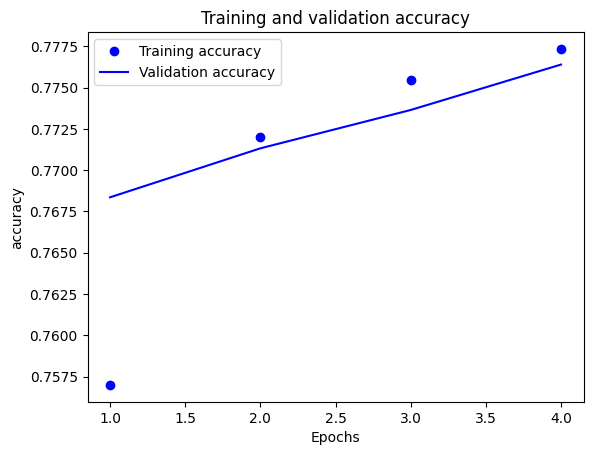

Train mse : [0.05581407621502876, 0.05455182492733002, 0.05446138605475426, 0.05439407005906105]
Validation mse : [0.05524437502026558, 0.05504191294312477, 0.055134598165750504, 0.05512974411249161]


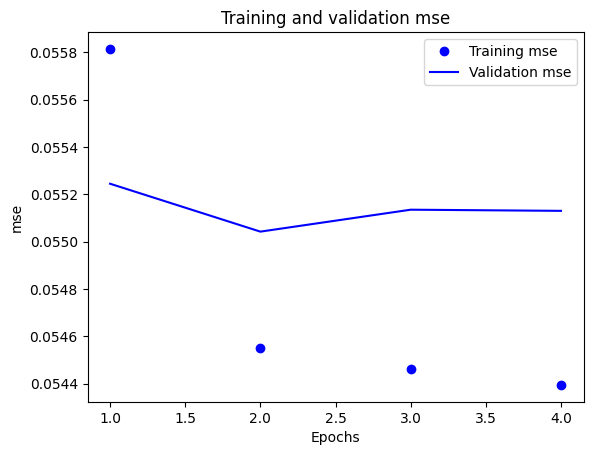


Performance on test set for model_9_4:
Exponent model mse : 0.7761998176574707
Mantissa model accuracy : 0.05522298067808151

Done with model_9_4.
-----------------------------------------------------


In [ ]:
model_save_directory = "model_17"
val_split = 0.2
test_split = 0.2
num_permutations = 5
batch_size = 128
random_state = 4542
epochs = 40
patience = 5
train_verbosity = 0
for model_name, model_info in models_dict.items():
    if model_name != "model_1":
        break
    filepath = samples_filepath + model_info['file_name']
    n = model_info['n']
    k = model_info['k']
    max_m_value = model_info['max_m_value']
    model_info['model'] = CustomModel(n=n, k=k, max_m_value=max_m_value)
    print(f"Loading data for model_{n}_{k}...")
    model_info['model'].load_and_preprocess_data(filepath)
    print(f"\nGenerating dataset for model_{n}_{k}...")
    model_info['model'].train_test_val_split(val_split=val_split, test_split=test_split, num_permutations=num_permutations, batch_size=batch_size, random_state=random_state)
    print(f"\nCompiling model for model_{n}_{k}...")
    model_info['model'].model_compile(build_exponent_model, build_mantissa_model, print_summary=False)
    print(f"\nTraining model for model_{n}_{k}...")
    model_info['model'].model_train(epochs=epochs, verbose=train_verbosity, patience=patience, model_save_directory=model_save_directory)
    print(f"\nPerformance on test set for model_{n}_{k}:")
    model_info['model'].evaluate_model(batch_size=batch_size)
    print(f"\nDone with model_{n}_{k}.")
    print("-----------------------------------------------------")

eval_inputs_combined = {}
eval_outputs_combined = {}

for model_name, model_info in models_dict.items():
    if model_name != "model_1":
        break
    for key in model_info['model'].eval_inputs.keys():
        if key not in eval_inputs_combined:
            eval_inputs_combined[key] = []
        eval_inputs_combined[key].extend(model_info['model'].eval_inputs[key])
    for key in model_info['model'].eval_outputs.keys():
        if key not in eval_outputs_combined:
            eval_outputs_combined[key] = []
        eval_outputs_combined[key].extend(model_info['model'].eval_outputs[key])

with gzip.open(model_save_directory+'/eval_inputs_combined', 'wb') as f:
            pickle.dump(eval_inputs_combined, f)
with gzip.open(model_save_directory+'/eval_outputs_combined', 'wb') as f:
            pickle.dump(eval_outputs_combined, f)


In [39]:
from tamu_csce_636_project1 import Evaluator
evaluator = Evaluator(
    first_name="Your Name",
    last_name="Your Name",
    email="email@tamu.edu",
    print=False,
)

In [42]:
def predict_and_evaluate(n, k, m, P_matrices):
    # Load models
    exponent_model_path = f'{model_save_directory}/model_{n}_{k}_exp.keras'
    mantissa_model_path = f'{model_save_directory}/model_{n}_{k}_mantissa.keras'
    
    exponent_model = tf.keras.models.load_model(exponent_model_path)
    mantissa_model = tf.keras.models.load_model(mantissa_model_path)
    
    # Prepare input
    P_matrices = np.array(P_matrices, dtype=np.float32)
    input_reshaped = P_matrices.reshape(len(P_matrices), k, n - k)

    # Predict full outputs
    exponent_logits = exponent_model.predict(input_reshaped, verbose=0)  # (batch, max_m_value, num_classes)
    predicted_exponents = np.argmax(exponent_logits, axis=-1)            # (batch, max_m_value)

    predicted_mantissas = mantissa_model.predict(input_reshaped, verbose=0)  # (batch, max_m_value)

    # Select only the m-1 index from each sample
    exponents_m_minus_1 = predicted_exponents[:, m - 1]     # shape: (batch,)
    mantissas_m_minus_1 = predicted_mantissas[:, m - 1]     # shape: (batch,)

    # Reconstruct m_height: mantissa * 10^exponent
    m_heights = mantissas_m_minus_1 * np.power(10.0, exponents_m_minus_1)

    return m_heights


In [43]:
model_save_directory = "model_17"
with gzip.open(model_save_directory+'/eval_inputs_combined', 'rb') as f:
    eval_inputs_combined = pickle.load(f)
with gzip.open(model_save_directory+'/eval_outputs_combined', 'rb') as f:
    eval_outputs_combined = pickle.load(f)
σ = evaluator.eval(
        inputs=eval_inputs_combined,
        outputs=eval_outputs_combined,
        func=predict_and_evaluate,
    )
average_σ = sum(σ.values()) / len(σ) if σ else 0
print(f"Average σ: {average_σ}")
for key, value in σ.items():
    print(f"{key}, σ: {value}")

Average σ: 1.8009031041374644
(9, 4, 2), σ: 0.6531680284172543
(9, 4, 3), σ: 0.24570468150132108
(9, 4, 4), σ: 2.3823778599018555
(9, 4, 5), σ: 3.922361846729426
